# Notebook d'exploration des données par thèmes étudiés

In [1]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
# Construction d'un DataFrame: structure de donnée tableau facilement manipulable avec Python.
df = pd.read_csv("sujets.csv") # Pour sujets.csv le fichier fourni de même nom.
df["annee"] = pd.to_numeric(df["annee"], errors="coerce")

In [4]:
dfClean = df[["X", "annee", "ch", "ticol", "transcription", "themat", "thes", "genre"]] # Construction d'un DataFrame ne contenant que les colonnes utilisées dans ce travail.
#dfClean.head()

## 1. Visualisation de la quantité de données par an

<Axes: title={'center': 'Nombre de lignes par année'}, xlabel='datdifsec'>

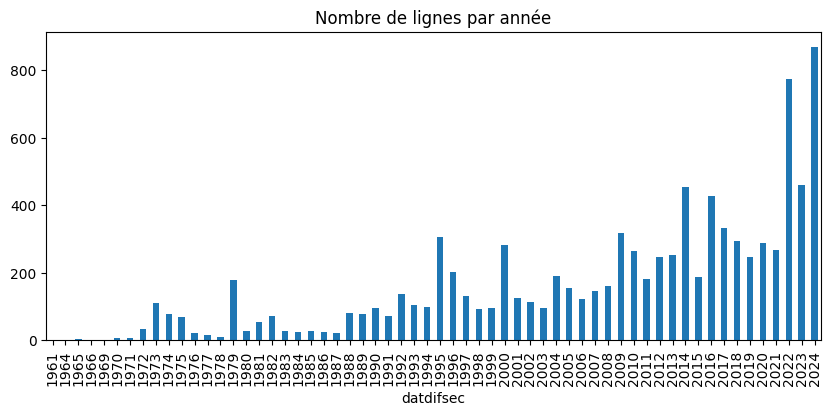

In [8]:
df_avortement=df.copy()
# Conversion de la colonne date en format "datetime" 
df_avortement["datdifsec"] = pd.to_datetime(df_avortement["datdifsec"], errors="coerce")

# Comptage du nombre de lignes par année
nb_lignes_par_an = (
    df_avortement["datdifsec"]
    .dt.year
    .value_counts()
    .sort_index()
)

nb_lignes_par_an.plot(kind="bar", figsize=(10,4), title="Nombre de lignes par année")

#### Observations
Croissance du nombre de données par an avec des fluctuations.

## 2. Traitement par thématiques (themat)

### 2.0 Exploration

In [10]:
# Fonction qui crée une liste de thématiques présentes dans un article
# Entrée: theme:List[str] > liste de thèmes présents dans l'article
#         listeThemes:List[str] > liste des thèmes conservés pour l'étude.
# Sortie: listPresentThemes:List[str] > liste des thèmes présents dans l'article et répertoriés dans listeThemes
def findTheme(theme, listeThemes):
    listPresentThemes = list()
    if "Médecine santé" in theme:
        listPresentThemes.append("Médecine_santé")
    theme = theme.split()
    for t in listeThemes:
        if t in theme:
            listPresentThemes.append(t)
    return listPresentThemes

In [12]:
listeThemesGlob = list(dfClean["themat"].unique())[1:] # Constitution liste de thèmes répertoriés (=toutes les thématiques citées dans "thema")
listeThemesGlob.append("Inconnu")  # Ajout d'un "Inconnu" pour gérer les articles sans thématique
listeThemes = [x for x in listeThemesGlob if "|" not in x] # Suppression des thématiques mixant plusieurs thématiques pour ne garder que les thèmes individuels.
# Les thématiques doubles seront traitées ensuite

In [14]:
dfThemes = dfClean.copy()
dfThemes["themat"] = dfThemes["themat"].fillna("Inconnu") # Remplissage des articles sans thématique par Inconnu pour éviter la casse et les trier ensuite
dfThemes["themeRationalized"] = dfThemes["themat"].apply(lambda x: findTheme(x, listeThemes)) # Attribution d'une liste de thématiques propre (sans double thèmes) à chaque article

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Fonction qui plot les thématiques étudiées pour chaque année.
def plot_weighted_theme_counts_by_year(
    df,
    year_col="annee",
    themes_col="themeRationalized",
    figsize=(14, 7),
    colormap="tab20"
):
    df = df.dropna(subset=[themes_col]).copy()

    df["n_themes"] = df[themes_col].apply(len)

    df_exploded = df.explode(themes_col)
    df_exploded["weight"] = 1 / df_exploded["n_themes"]

    weighted_counts = (
        df_exploded
        .groupby([year_col, themes_col])["weight"]
        .sum()
        .unstack(fill_value=0)
        .sort_index()
    )
    ax = weighted_counts.plot(
        kind="bar",
        stacked=True,
        figsize=figsize,
        colormap=colormap
    )

    ax.set_xlabel("Année")
    ax.set_ylabel("Nombre d'articles")
    ax.set_title("Nombre d'articles par thème et par année (pondéré)")
    ax.legend(title="Thèmes", bbox_to_anchor=(1.05, 1), loc="upper left")

    plt.tight_layout()
    plt.show()


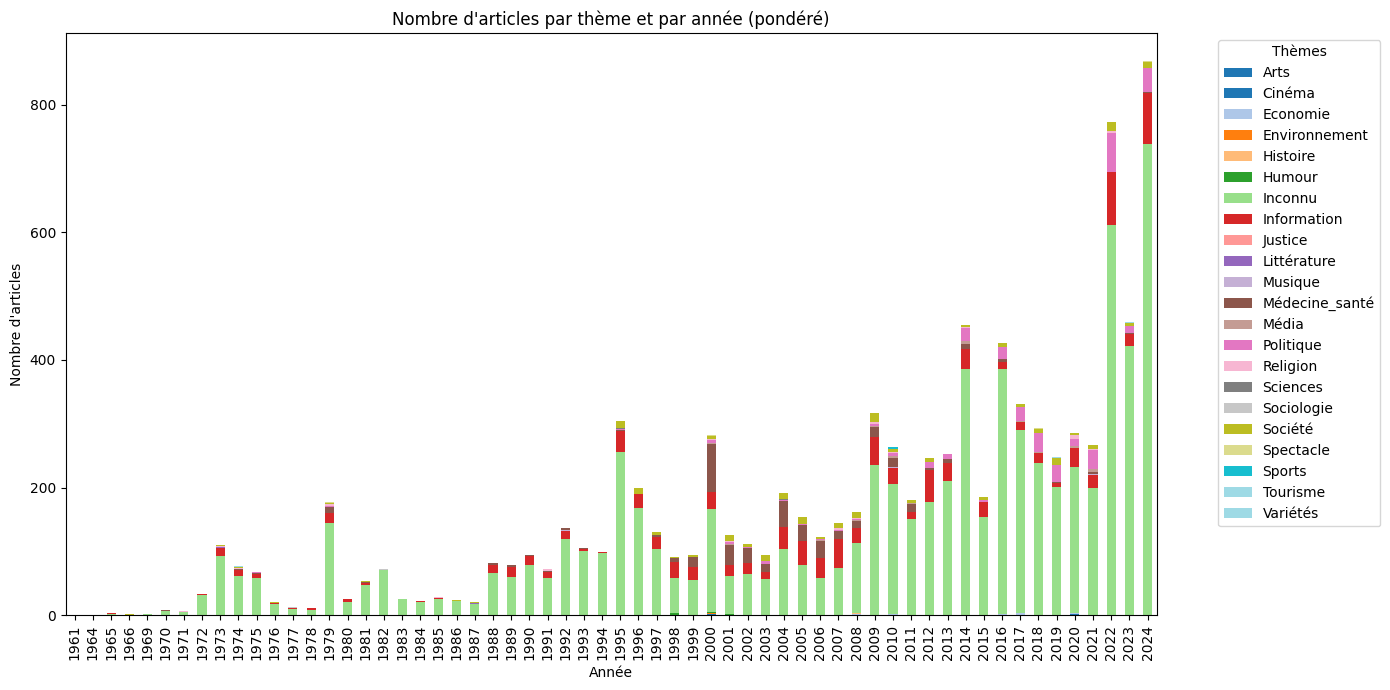

In [17]:
plot_weighted_theme_counts_by_year(dfThemes)

#### Observations
Immense majorité d'inconnus de manière relativement stable au cours du temps. Peu de thématiques répertoriées de manière générale. 

In [18]:
dfWithoutInconnu = dfThemes[dfThemes["themeRationalized"].str.len() > 1] # Suppression des articles sans thématiques répertoriées.

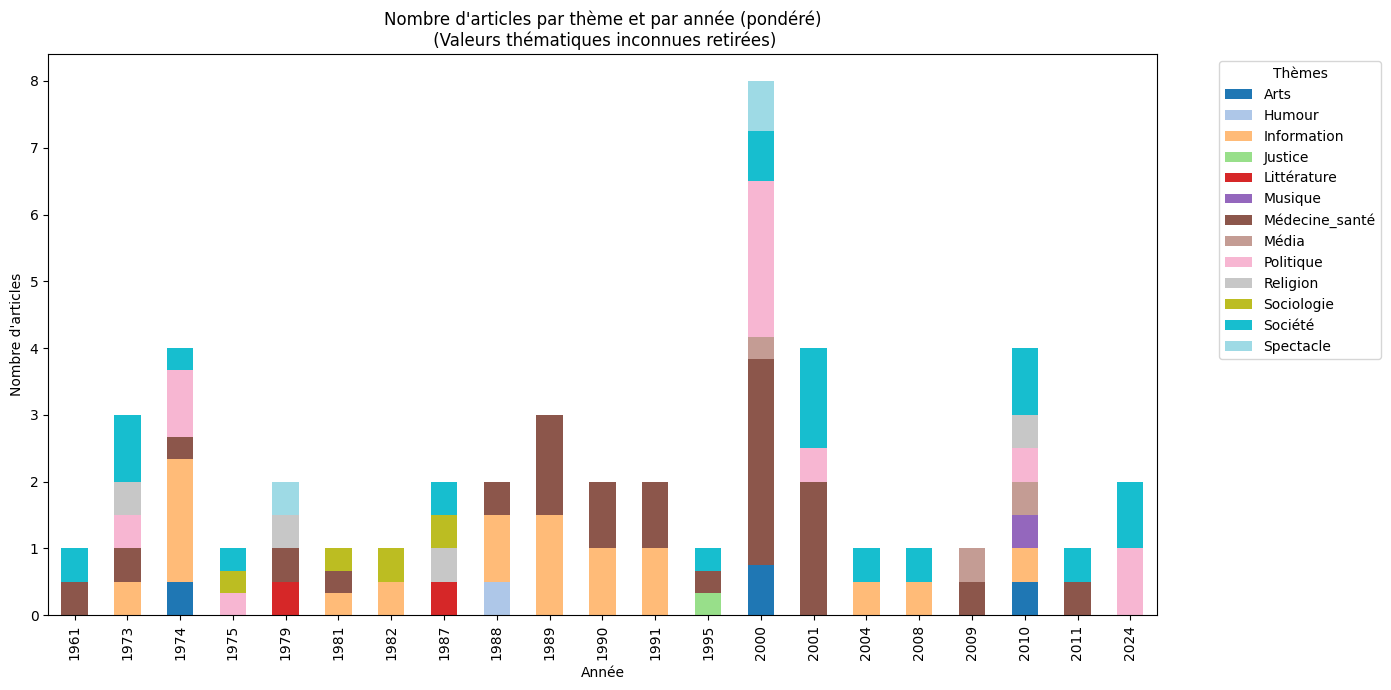

In [146]:
plot_weighted_theme_counts_by_year(dfWithoutInconnu)

#### Observations
Très peu d'articles. Beaucoup d'articles traitant de la santé, d'information de politique. Dans l'ensemble, c'est très varié et peu représentatif.

## 3. Traitement par thèmes (thes)

In [19]:
# Pipeline : récupérer les mots de thésaurus et les mettre sous forme de liste, supprimer les moins fréquents et plot

# Fonction qui formatte les thèmes: séparation des thèmes doubles (avec un | qui sépare les deux thèmes répertoriés) en deux thèmes et met un '_' 
# à la place des espaces dans les thèmes en deux mots
# Entrée: thes:List[str] > Liste de thèmes à formatter
# Sortie: formattedThes:List[str] > Liste de thèms formattés.
def formatThes(thes):
    splittedThes = thes.split(sep="|")
    strippedThes = [x.strip() for x in splittedThes]
    formattedThes = [s.replace(" ", "_") for s in strippedThes if (s[0] < 'A' or s[0] > 'Z')]

    return formattedThes

# Fonction qui supprime d'un DataFrame les thèmes les moins communs de façon à ne garder que des thèmes majeurs, pour la lisibilité
# Entrée: df:pandas.DataFrame > DataFrame qui répertorie des articles avec la colonne "thes" renseignée.
# Sortie: df:pandas.DataFrame > DataFrame avec pour chaque article la liste de ses thèmes les plus courants.
def removeLeastCommon(df):
    theme_counts = df["thesRationalized"].explode().value_counts()
    cutoff = int(len(theme_counts) * 0.03)
    themes_to_keep = list(theme_counts.iloc[:cutoff].index)
    themes_to_keep.remove("avortement")

    df["thesRationalized"] = df["thesRationalized"].apply(
                                                            lambda lst: [t for t in lst if t in themes_to_keep]
                                                            if isinstance(lst, list) else lst
                                                            )
    df = df[df["thesRationalized"].map(len) > 0]
    return df

In [21]:
dfThes = dfClean.copy()
dfThes["thes"] = dfThes["thes"].fillna("Inconnu")
dfThes["thesRationalized"] = dfThes["thes"].apply(lambda x: formatThes(x))
dfThes = removeLeastCommon(dfThes)

In [23]:
#dfThes["thesRationalized"].head()

/var/folders/vd/pxnj9pz113b1djlzh_4bfc240000gn/T/ipykernel_19834/2684100191.py:52: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


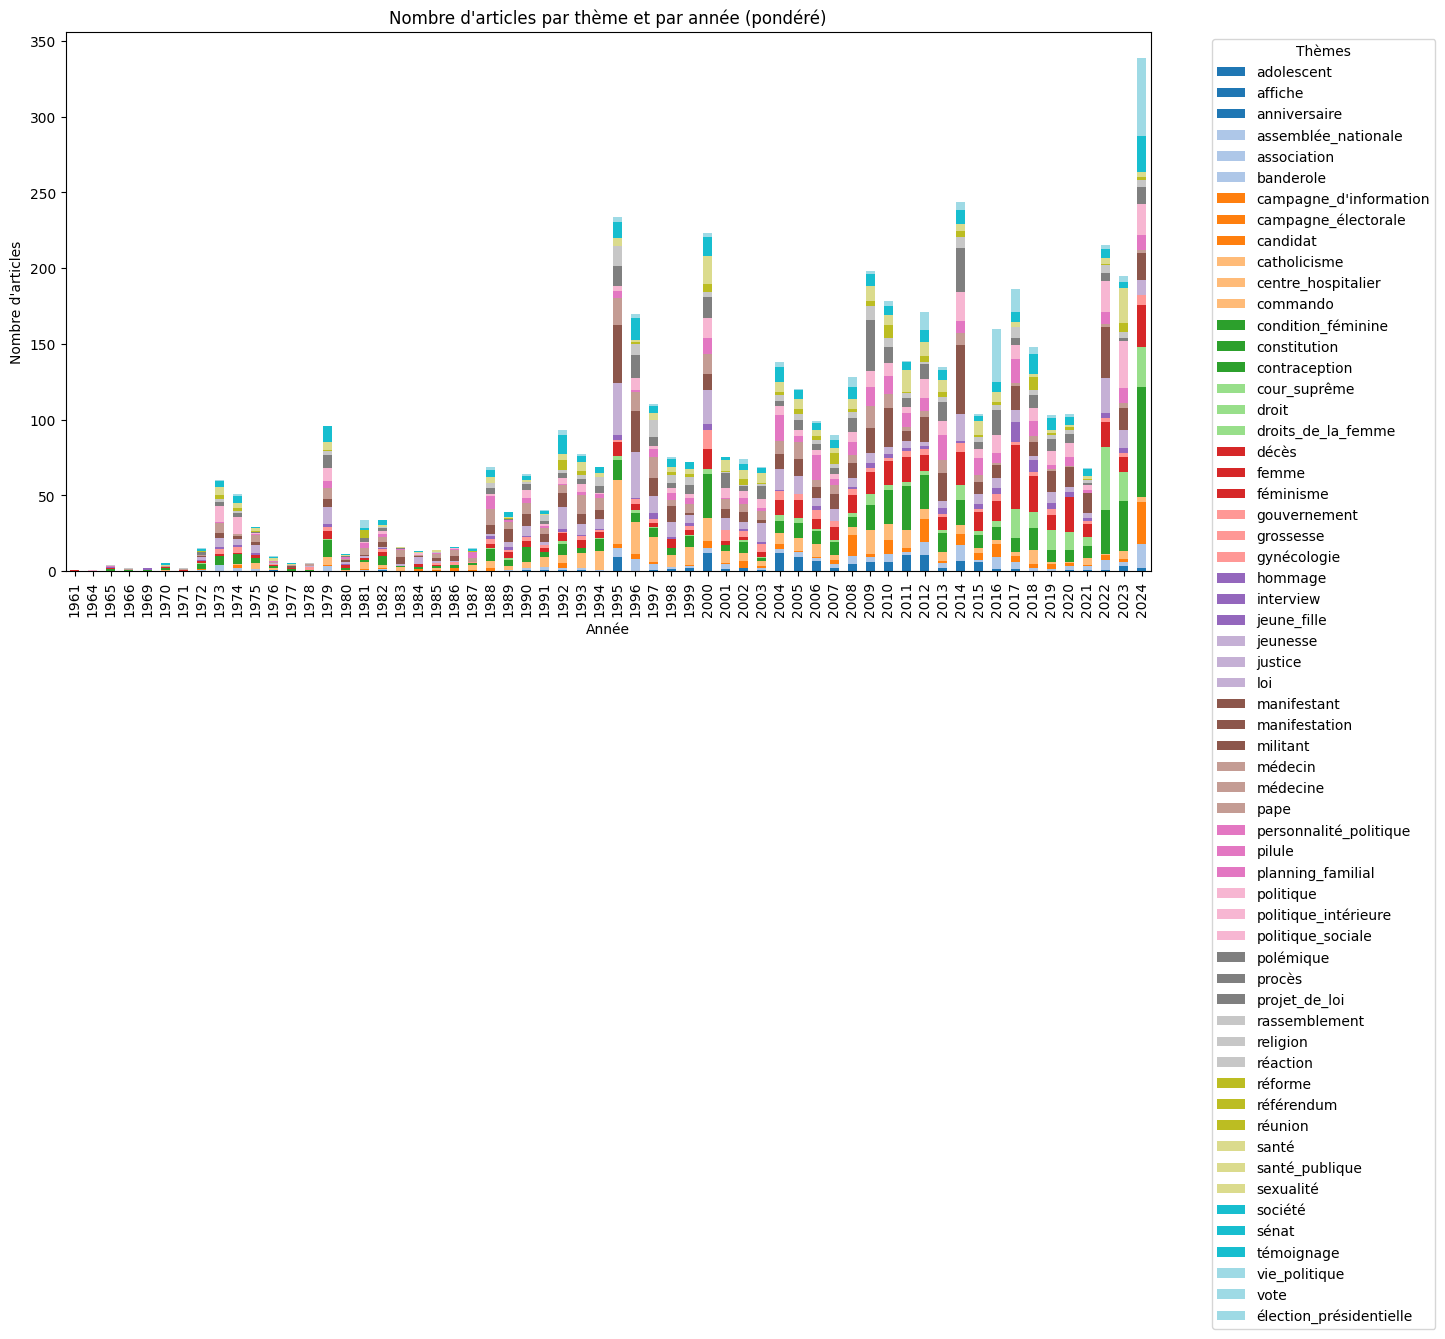

In [24]:
# Plot des thèmes répertoriés pour chaque année
plot_weighted_theme_counts_by_year(df=dfThes, year_col="annee", themes_col="thesRationalized", figsize=(14, 7), colormap="tab20")

#### Observations
Graphique très dense avec des thèmes qui peuvent se recouper en superthèmes. 

### 2.1 Visualisation par grands thèmes

In [26]:
# Dictionnaire de grands thèmes rassemblant tous les sous-thèmes trouvés dans la liste des thèmes les plus récurrents en des superthèmes.
dicoThematiques = {
    "feminisme": ["condition_féminine", "droits_de_la_femme", "femme", "feminisme"],
    "médical": ["centre_hospitalier", "contraception", "décès", "grossesse", "gynécologie", "médécin", "médecine", "pilule", "santé", "santé_publique", "sexualité"],
    "juridique": ["assemblée_nationale", "cour_supreme", "droit", "justice", "loi", "procès", "projet_de_loi", "réforme", "référendum", "sénat", "vote", "constitution"],
    "politique": ["affiche", "campagne_électorale", "campagne_d'information", "candidat", "gouvernement", "hommage", "personnalité_politique", "politique", "politique_intérieure", "politique_sociale", "projet_de_loi", "polémique", "rassemblement", "vie_politique", "élection_présidentielle"],
    "social": ["association", "banderole", "hommage", "manifestant", "manifestation", "militant", "rassemblement", "société", "témoignage"],
    "jeunesse": ["adolescent", "jeune_fille", "jeunesse"],
    "religion": ["catholiscisme", "pape", "religion"]
}

In [29]:
# Fonction qui plot les superthèmes pour chaque année.
def plot_weighted_supertheme_counts_by_year(
    df,
    supertheme_dict,
    year_col="annee",
    themes_col="thesRationalized",
    figsize=(14, 7),
    colormap="tab20"
):
    df = df.dropna(subset=[themes_col]).copy()
    theme_to_super = {theme: super_cat 
                      for super_cat, theme_list in supertheme_dict.items()
                      for theme in theme_list}
    def map_to_super(lst):
        return [theme_to_super[t] for t in lst if t in theme_to_super]

    df["super_themes"] = df[themes_col].apply(map_to_super)

    df = df[df["super_themes"].map(len) > 0]
    df["n_themes"] = df["super_themes"].apply(len)
    df_exploded = df.explode("super_themes")
    df_exploded["weight"] = 1 / df_exploded["n_themes"]
    weighted_counts = (
        df_exploded
        .groupby([year_col, "super_themes"])["weight"]
        .sum()
        .unstack(fill_value=0)
        .sort_index()
    )

    ax = weighted_counts.plot(
        kind="bar",
        stacked=True,
        figsize=figsize,
        colormap=colormap
    )

    ax.set_xlabel("Année")
    ax.set_ylabel("Nombre d'articles")
    ax.set_title("Nombre d'articles par super-thème et par année (pondéré)")
    ax.legend(title="Super-thèmes", bbox_to_anchor=(1.05, 1), loc="upper left")

    plt.tight_layout()
    plt.show()

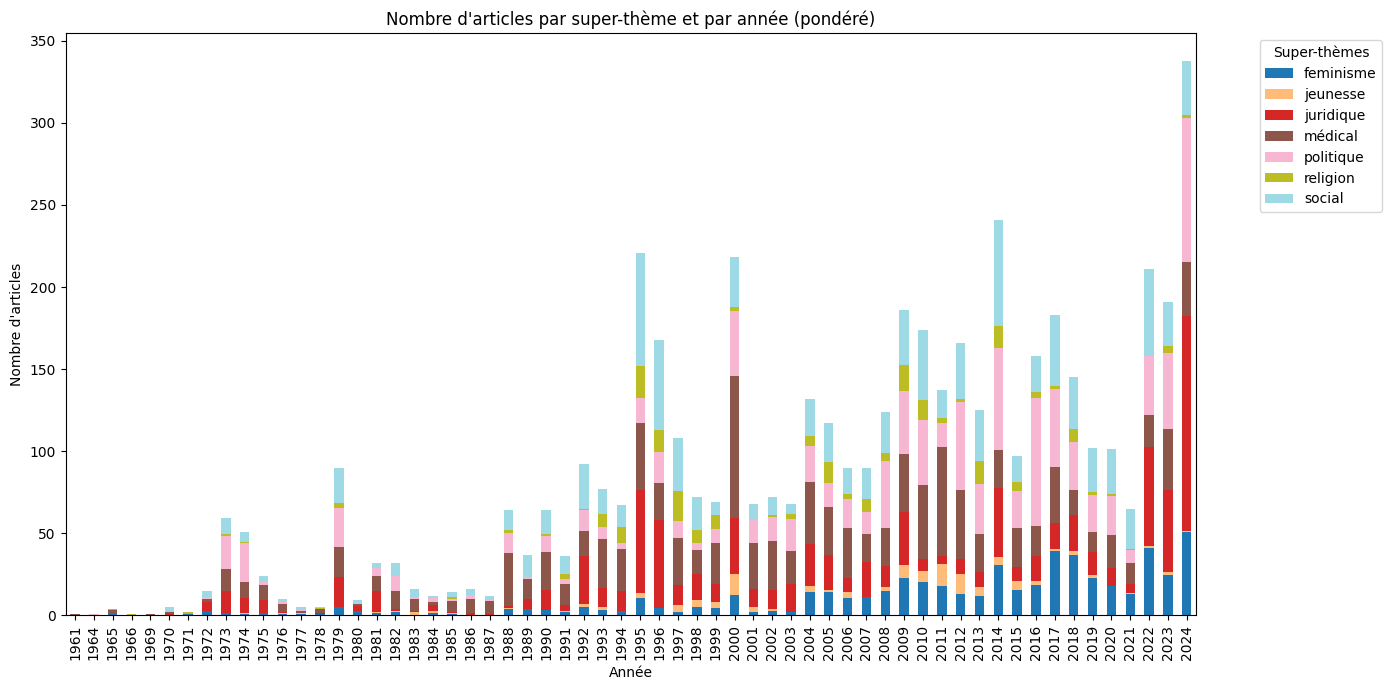

In [240]:
plot_weighted_supertheme_counts_by_year(dfThes, dicoThematiques)

#### Observations
Il n'y a pas vraiment de tendance qui se dégage réellement des données. Éventuellement, de plus en plus de féminisme. Mais c'est aussi lié au fait qu'il y a de plus en plus d'articles répertoriés.

In [33]:
# Construction de sous-plots représentant le nombre d'articles par an pour chaque supercatégorie.
def plot_supertheme_fraction_by_year(
    df,
    supertheme_dict,
    year_col="annee",
    themes_col="thesRationalized",
    figsize=(16, 12),
    n_rows=4,
    n_cols=2,
    colormap="tab20"
):
    """
    Creates subplots (one per super-theme) showing the fraction of articles per year
    assigned to that super-theme. Fractions sum to 1 per year across all super-themes.
    """

    # Drop missing themes
    df = df.dropna(subset=[themes_col]).copy()

    theme_to_super = {theme: super_cat 
                      for super_cat, theme_list in supertheme_dict.items()
                      for theme in theme_list}

    
    df_exploded = df.explode(themes_col)
    df_exploded = df_exploded[df_exploded[themes_col].isin(theme_to_super)]
    df_exploded["super_theme"] = df_exploded[themes_col].map(theme_to_super)
    df_exploded = df_exploded.reset_index()  # column "index" = original row

    df_super = df_exploded.drop_duplicates(subset=[year_col, "super_theme", "index"])

    super_counts = df_super.groupby(["super_theme", year_col]).size().unstack(fill_value=0)
    super_frac = super_counts.div(super_counts.sum(axis=0), axis=1)
    
    n_super = len(supertheme_dict)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize, sharex=True)
    axes = axes.flatten()

    for ax, super_theme in zip(axes, supertheme_dict.keys()):
        if super_theme in super_frac.index:
            ax.bar(super_frac.columns, super_frac.loc[super_theme], color=plt.colormaps[colormap](0.5))
        ax.set_title(super_theme)
        ax.set_ylabel("Fraction")
        ax.set_xlabel("Année")
        ax.set_xticks(super_frac.columns)
        ax.set_xticklabels(super_frac.columns, rotation=45, ha="right")
        ax.set_ylim(0, 1)

    for ax in axes[len(supertheme_dict):]:
        ax.set_visible(False)

    plt.tight_layout()
    plt.show()


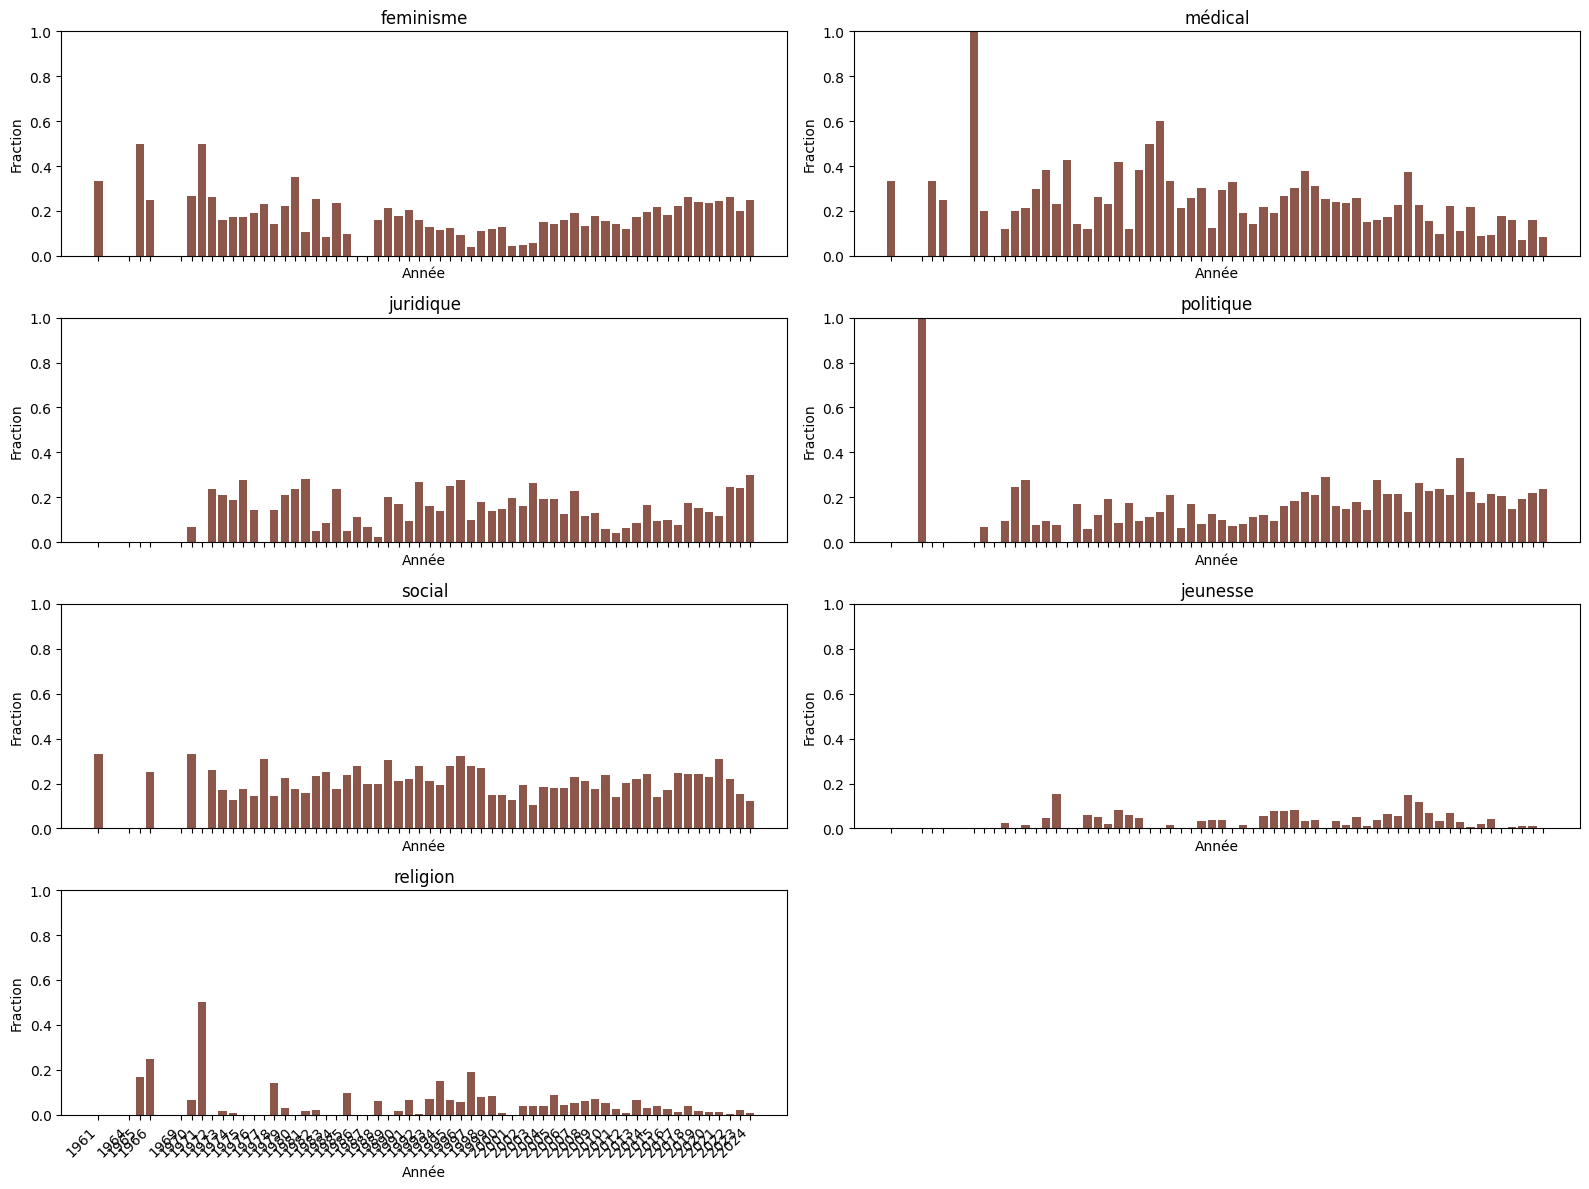

In [31]:
plot_supertheme_fraction_by_year(dfThes, dicoThematiques)

#### Observations
Il n'y a pas vraiment de différence notable par thème en terme de progression. C'est quand même de manière générale de moins en moins médical et de plus en plus juridique.

In [37]:
# Fonction qui plot la proportion d'apparition de chaque sous-thème pour chaque colonne "x_col" pour chaque superthème.
# (un thème aura une présence de 1/n s'il est mentionné avec n-1 autres thèmes dans le même article pour l'article en question). 
def plot_supertheme_with_subthemes_fraction_ch(
    df,
    supertheme_dict,
    x_col="ch", # ou annee             
    themes_col="thesRationalized",
    x_ticks_list=None,        
    figsize=(18, 14),
    n_rows=4,
    n_cols=2,
    colormap="tab20",
    figname="figure.png"
):
    df = df.dropna(subset=[themes_col]).copy()
    
    theme_to_super = {theme: super_cat 
                      for super_cat, theme_list in supertheme_dict.items()
                      for theme in theme_list}

    df_exploded = df.explode(themes_col)
    df_exploded = df_exploded[df_exploded[themes_col].isin(theme_to_super)]
    df_exploded["super_theme"] = df_exploded[themes_col].map(theme_to_super)
    df_exploded = df_exploded.reset_index()  # column "index" = original row
    
    df_super = df_exploded.drop_duplicates(subset=[x_col, "super_theme", themes_col, "index"])
    
    counts = df_super.groupby(["super_theme", themes_col, x_col]).size().unstack(fill_value=0)

    total_per_x = counts.sum(axis=0)
    counts_frac = counts.div(total_per_x, axis=1)

    if x_ticks_list is not None:
        counts_frac = counts_frac[[c for c in counts_frac.columns if c in x_ticks_list]]
        xticks_to_use = [c for c in x_ticks_list if c in counts_frac.columns]
    else:
        xticks_to_use = counts_frac.columns
        
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize, sharex=False)
    axes = axes.flatten()
    
    for ax, super_theme in zip(axes, supertheme_dict.keys()):
        if super_theme in counts_frac.index:
            df_plot = counts_frac.loc[super_theme]
            bottom = pd.Series([0]*df_plot.shape[1], index=df_plot.columns)
            cmap = plt.colormaps[colormap]
            colors = [cmap(i / df_plot.shape[0]) for i in range(df_plot.shape[0])]
            for subtheme, color in zip(df_plot.index, colors):
                ax.bar(df_plot.columns, df_plot.loc[subtheme], bottom=bottom, color=color, label=subtheme)
                bottom += df_plot.loc[subtheme]
            ax.legend(fontsize=9, title="Sub-themes")
    
        ax.set_title(super_theme)
        ax.set_ylabel("Fraction of articles")
        ax.set_xlabel(x_col)
        ax.set_xticks(xticks_to_use)
        ax.set_xticklabels(xticks_to_use, rotation=90, ha="center")
        
    for ax in axes[len(supertheme_dict):]:
        ax.set_visible(False)

    plt.tight_layout()
    plt.savefig(figname)
    plt.show()


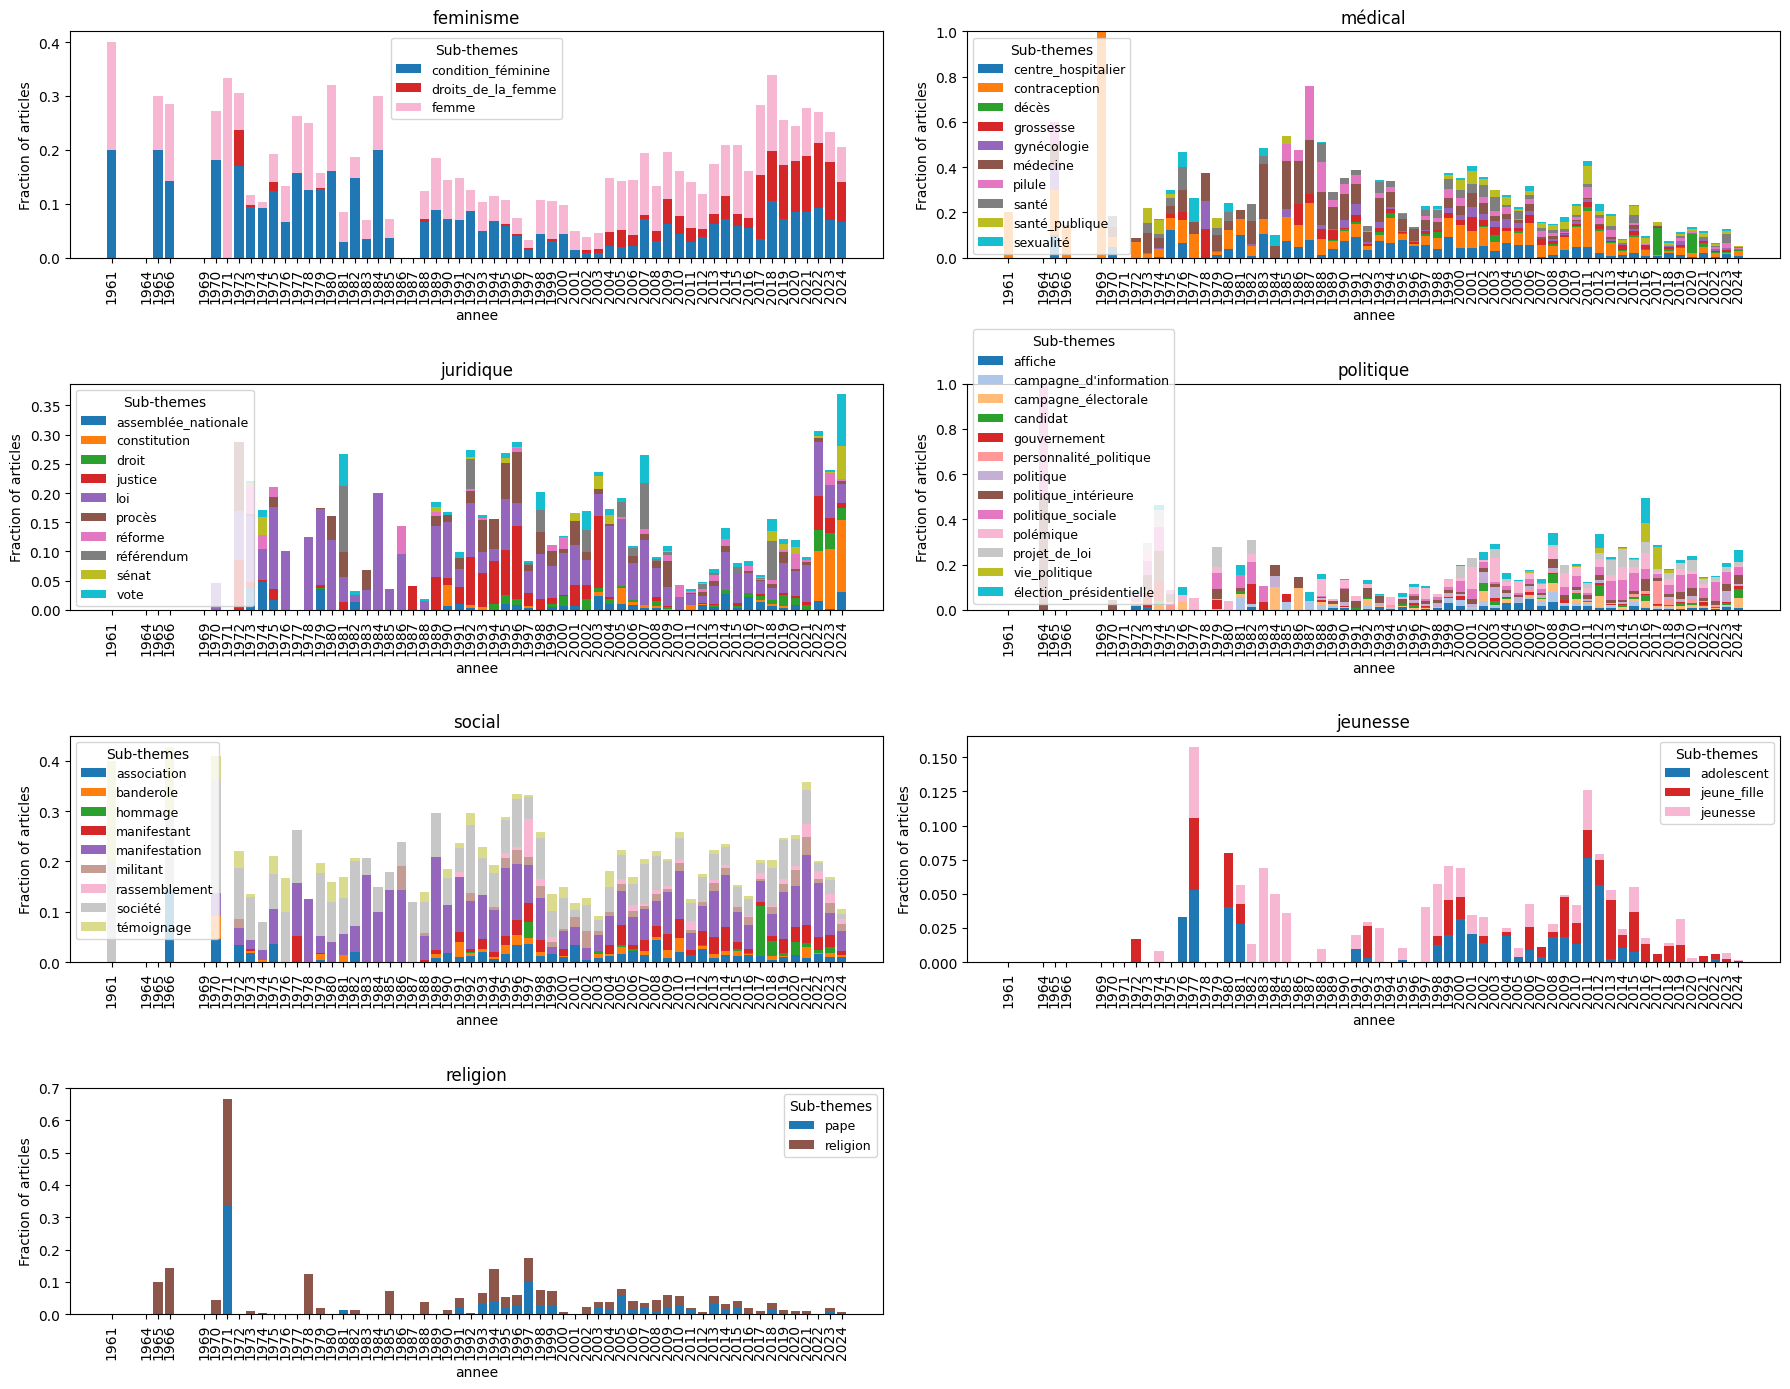

In [497]:
plot_supertheme_with_subthemes_fraction_ch(dfThes, x_col="annee", supertheme_dict=dicoThematiques, figname="themesPerYear.png")

#### Observations
* Apparition des droits de la femme dans les années 2000,
* Pic de thèmes juridiques entre 2022 et 2024, vote en priorité au moment de la question de l'entrée dans la constitution du droit à l'avortement.
* Pic de vie politique et  d'électione présidentielles à chaque année d'élections, en particulier en 2016.

### 2.2 Visualisation par chaîne

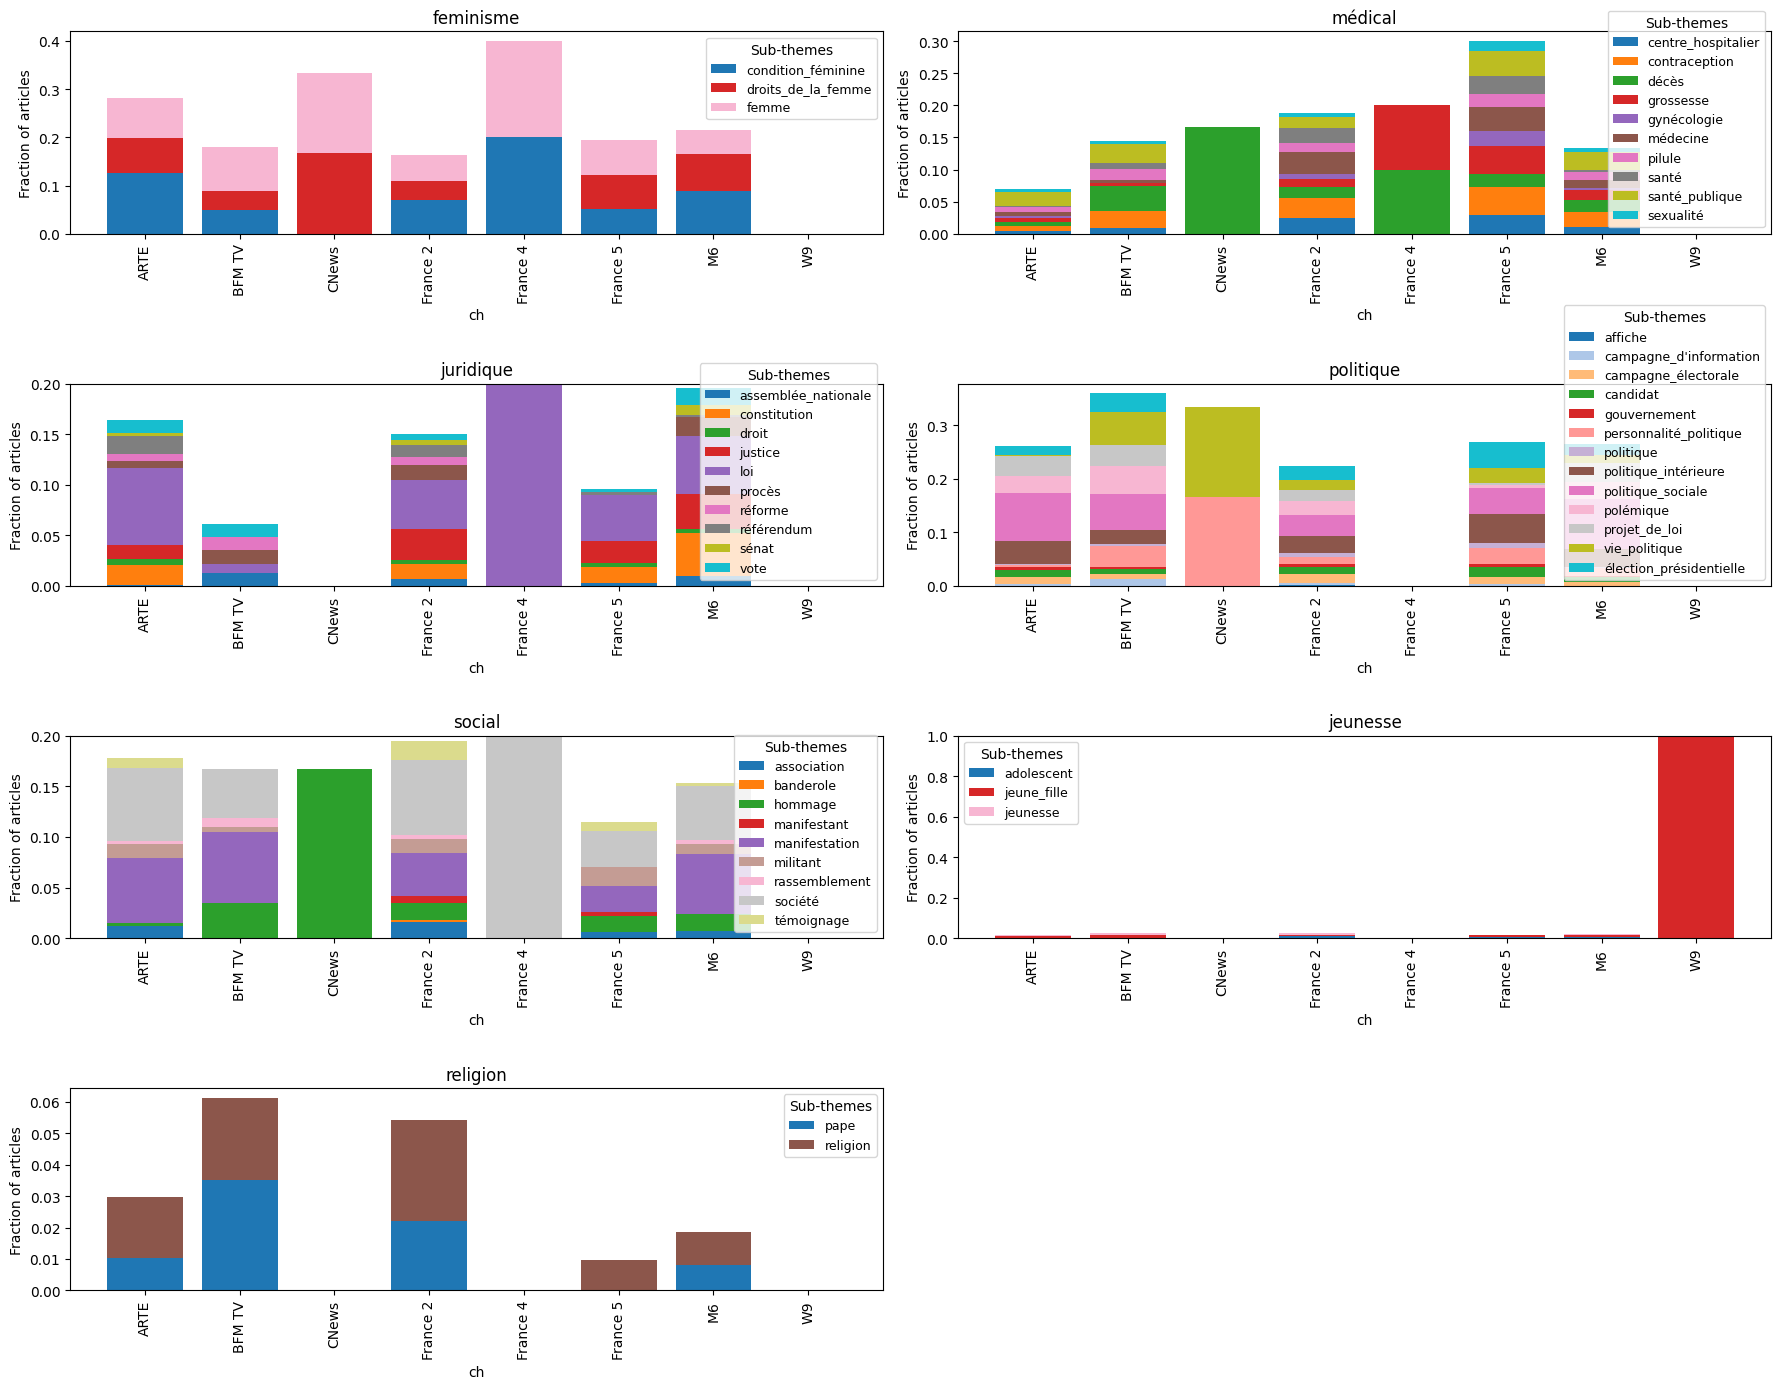

In [38]:
# Plot de la proportion d'apparition des sous-thèmes pour chaque chaîne pour chaque superthème.
plot_supertheme_with_subthemes_fraction_ch(
    df=dfThes,
    supertheme_dict=dicoThematiques,
    x_col="ch",
    themes_col="thesRationalized",
    x_ticks_list = ["M6", "France 2", "ARTE", "France 5", "C8", "CNews", "France 4", "BFM TV", "D8", "W9"],
    figsize=(18, 14),
    n_rows=4,
    n_cols=2,
    colormap="tab20",
    figname="themesPerChannel.png"
)

#### Observations
Certaines chaînes ont une diversité beaucoup plus faible de sujets traités (CNews ne parle que d'hommages pour le social et de décès pour le médical, France 4 ne parle que de loi pour le juridique).  
Ces résulats dépendent aussi du nombre d'articles par chaîne par superthème. La somme des pourcentages d'une chaîne pour l'ensemble des superthèmes donne 1. Il est probable qu'on n'ait répertorié de CNews qu'un seul article traitant de sujets sociaux pour un nombre total d'articles assez faible, ce qui explique le manque de diversité, là où on a répertorié de France 2 beaucoup plus d'articles de manière générale.  
Certaines chaines traitent d'angles très diversifiés (France 5 et BFM, par exemple).

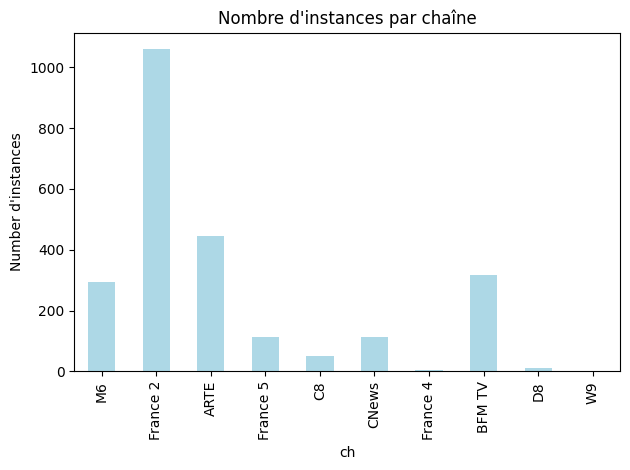

In [39]:
# Nombre d'articles répertoriés par chaîne choisie pour être représentée dans le graphique précédent.
ch_list = ["M6", "France 2", "ARTE", "France 5", "C8", "CNews", "France 4", "BFM TV", "D8", "W9"]
#ch_list = df["ch"].unique()

#counts = (
#    df["ch"].value_counts().reindex(ch_list, fill_value=0).head(15)
#    if len(ch_list) > 0
#    else df["ch"].value_counts().head(15)
#)

counts = df["ch"].value_counts().reindex(ch_list, fill_value=0) if ch_list else df["ch"].value_counts()

# Plot
plt.figure()
counts.plot(kind="bar", color="lightblue")
plt.xlabel("ch")
plt.ylabel("Number d'instances")
plt.title("Nombre d'instances par chaîne")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("Nombre d'instances par chaîne")
plt.show()

## 3. Traitement de la tendance pro ou anti droit à l'avortement

In [40]:
# Constitution de listes de thèmes qui connotent un discours pro ou anti droit à l'avortement.
pro_avortement = [
    "choix", "liberte", "autonomie", "sante", "reproductive",
    "legal", "securisee", "femme", "egalite", "contraception",
    "droits", "protection", "planification", "maternite",
    "decision", "acces", "soutien", "prevention", "controle", "securite"
]

anti_avortement = [
    "vie", "foetus", "enfant", "naissance", "conception",
    "sacre", "bebe", "provie", "interdiction", "lutte",
    "defense", "moralite", "famille", "responsabilite",
    "respect", "opposition", "antiivg", "innocent", "naturel",
    "precieux",
    "meurtre", "assassinat", "suppression", "elimination", "destruction", "homicide"
]

In [42]:
# Fonction qui plot la fréquence de mots connotant un thème ou un autre pour chaque chaîne.
def plotWordFrequencyPerX(df, X, toSearch, toSearchName, titre="Pro Avortement vs Anti Avortement"):
    dfClean = df[df["transcription"].notna()].copy()
    texts = dfClean["transcription"]
    nbCat = len(toSearch)
    colors = ["navy", "red"]
    plt.figure(figsize=(10,6))
    
    for catNumber in range(nbCat):
        frequencies = list()
        category = toSearch[catNumber]
        for text in texts:
            splittedText = text.split()
            frequencies.append(len([x for x in splittedText if x in category])/len(splittedText))
            
        dfClean[toSearchName[catNumber]] = frequencies
    
        dfGrouped = dfClean.groupby(X)[toSearchName[catNumber]].sum()
        
        plt.bar(dfGrouped.index, dfGrouped.values, color=colors[catNumber])
        plt.xlabel(X)
        plt.ylabel(toSearchName[catNumber])
        plt.xticks(rotation=90)  # rotate x labels if needed
        plt.tight_layout()

    plt.title(titre)
    plt.show()
    

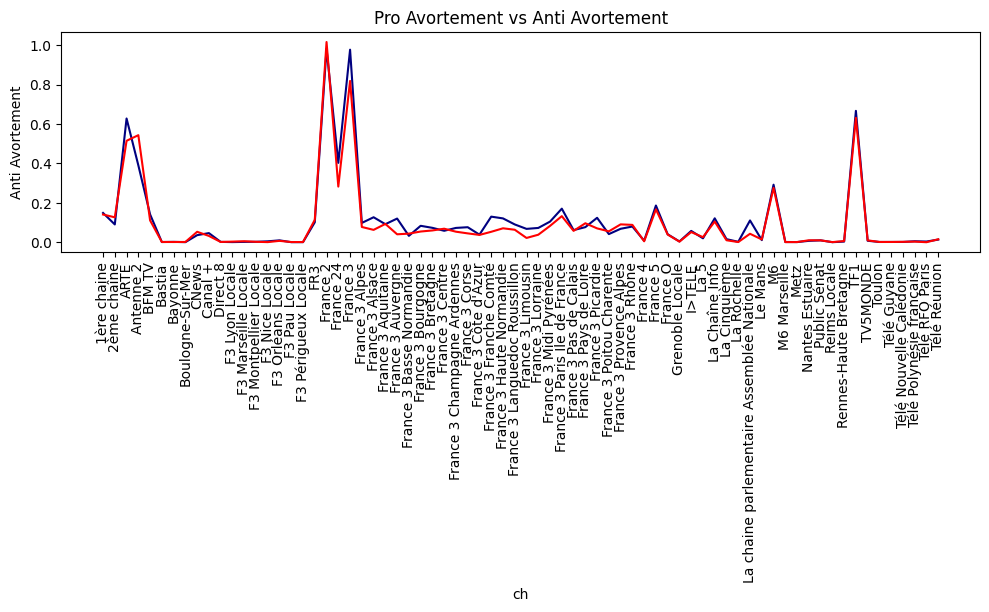

In [438]:
plotWordFrequencyPerX(dfThes, "ch", [pro_avortement, anti_avortement], ["Pro Avortement",  "Anti Avortement"])

#### Observations
Tendances semblables pour les deux courbes, certaines chaînes semblent simplement utiliser plus de thèmes connotés de manière générale que d'autres.

In [43]:
# Fonction qui plot la fréquence de mots connotant un thème ou un autre pour chaque chaîne en barres superposées (dont la somme fait 1)
def plotWordFrequencyPerXStacked(df, X, toSearch, toSearchName, order_by=None, ascending=True, figname="figure.png"):
    dfClean = df[df["transcription_precis"].notna()].copy()
    texts = dfClean["transcription_precis"]

    for catNumber, category in enumerate(toSearch):
        frequencies = []
        for text in texts:
            splittedText = text.split()
            if (len(text) == 0 or len(splittedText) == 0):
                frequencies.append(0)
            else:
                frequencies.append(len([x for x in splittedText if x in category])/len(splittedText))
        dfClean[toSearchName[catNumber]] = frequencies

    dfGrouped = (
        dfClean
        .groupby(X)[toSearchName]
        .sum()
        .fillna(0)
    )
    
    dfNormalized = dfGrouped.div(dfGrouped.sum(axis=1), axis=0).fillna(0)

    if order_by is not None:
        dfNormalized = dfNormalized.sort_values(
            by=order_by,
            ascending=ascending
        )

    plt.figure(figsize=(10,6))
    bottom = np.zeros(len(dfNormalized))
    colors = ["navy", "red"]

    for i, name in enumerate(toSearchName):
        plt.bar(
            dfNormalized.index,
            dfNormalized[name].values,
            bottom=bottom,
            label=name,
            color=colors[i]
        )
        bottom += dfNormalized[name].values

    plt.xlabel(X)
    plt.ylabel("Proportion of occurrences")
    plt.title("Pro Avortement vs Anti Avortement (normalized)")
    plt.xticks(rotation=90)
    plt.legend()
    plt.tight_layout()
    plt.savefig(figname)
    plt.show()

In [44]:
import re

mots_avortement = ['avortement', 'ivg', 'interruption volontaire de grossesse']

# Fonction qui ne conserve que les phrases autour de mots indiquant clairement l'IVG, pour éviter de récupérer des mots-clef pro ou anti
# droit à l'avortement dits hors-contexte, ce qui biaiserait les résultats.
def extraire_context_avortement(transcription: str) -> str:
    if pd.isna(transcription) or not transcription.strip():
        return ''

    phrases = re.split(r'(?<=[.!?])\s+', transcription.strip())
    phrases = [p.strip() for p in phrases if p.strip()]
    
    contexts = []
    
    for i, phrase in enumerate(phrases):
        if any(mot.lower() in phrase.lower() for mot in mots_avortement):
            debut = max(0, i - 1)
            fin = i + 1
            for j in range(1, 3):
                if i + j < len(phrases):
                    fin += 1
                else:
                    break

            
            context_phrases = list(set(phrases[debut:fin]))  
            context = ' '.join(context_phrases)
            contexts.append(context)

    
    unique_contexts = list(set(contexts))
    return '; '.join(unique_contexts) if unique_contexts else ''


In [45]:
df_avortement = dfClean.copy()
df_avortement['transcription_precis'] = df_avortement['transcription'].apply(extraire_context_avortement)

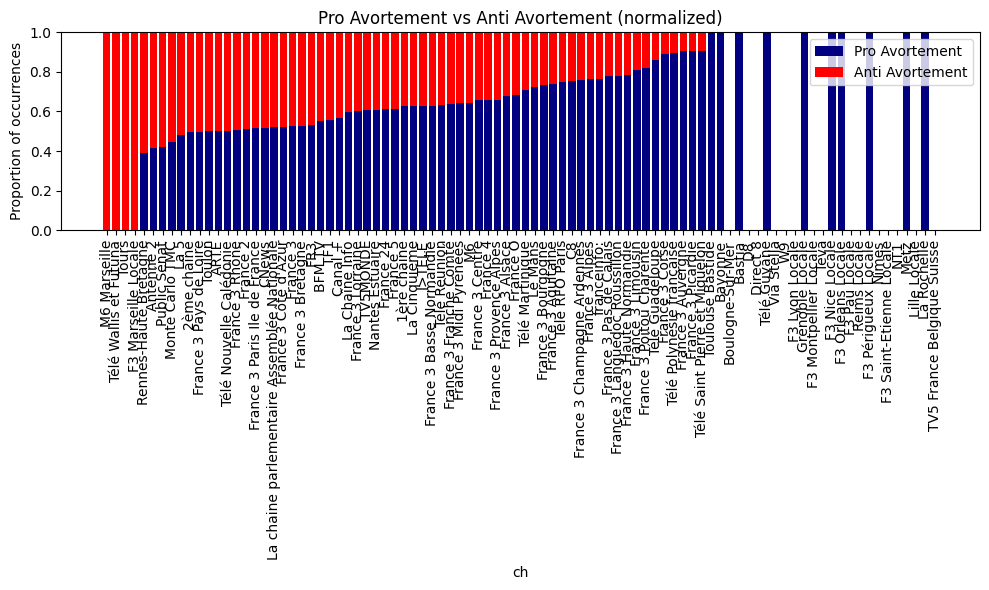

In [597]:
plotWordFrequencyPerXStacked(df_avortement, "ch", [pro_avortement, anti_avortement], ["Pro Avortement",  "Anti Avortement"], order_by="Anti Avortement",
    ascending=False, figname="proAntiAvortementPerChannelClean")

#### Observations
Quelques chaînes ont tendance à être plus pro ou plus anti, comme répertoriées sur les extrémités du grapgique. Mais de manière générale, les chaînes sont plutôt dans entre-deux proche du 50/50.

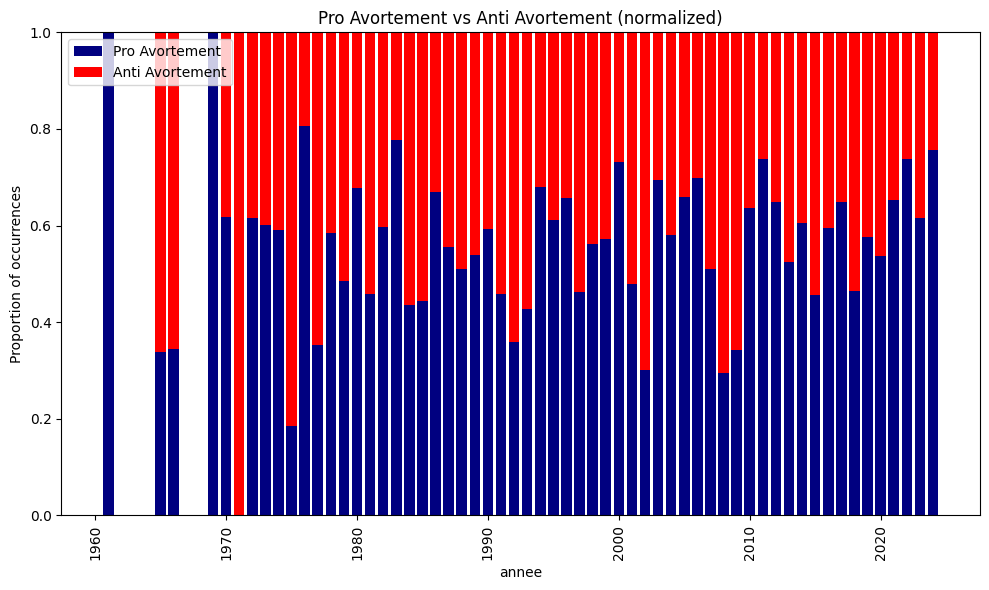

In [602]:
plotWordFrequencyPerXStacked(df_avortement, "annee", [pro_avortement, anti_avortement], ["Pro Avortement",  "Anti Avortement"], order_by="Anti Avortement",
    ascending=False, figname="proAntiAvortementPerYearClean")

#### Observations
Pas de tendance claire au fur et à mesure du temps.